In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
import tensorflow as tf

In [36]:
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [37]:
nbatch = 16

train_datagen = ImageDataGenerator( rescale=1./255,
                                    rotation_range=10.,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=0.2,
                                    horizontal_flip=True
                                  )

test_datagen  = ImageDataGenerator( rescale=1./255 )

train_gen = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/Finger_dataset/train',
        target_size=(128, 128),
        color_mode='grayscale',
        batch_size=nbatch,
        classes=['0','1','2','3','4','5'],
        class_mode='categorical'
    )

test_gen = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/Finger_dataset/test',
        target_size=(128, 128),
        color_mode='grayscale',
        batch_size=nbatch,
        classes=['0','1','2','3','4','5'],
        class_mode='categorical'
    )

valid_gen = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/Finger_dataset/val',
        target_size=(128, 128),
        color_mode='grayscale',
        batch_size=nbatch,
        classes=['0','1','2','3','4','5'],
        class_mode='categorical'
    )

Found 1200 images belonging to 6 classes.
Found 475 images belonging to 6 classes.
Found 450 images belonging to 6 classes.


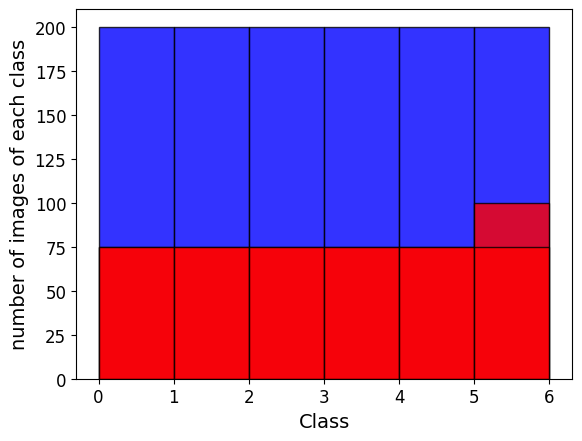

In [98]:
h1,_,_ = plt.hist(train_gen.classes, bins=range(0,7), alpha=0.8, color='blue', edgecolor='black')
h2,_,_ = plt.hist(test_gen.classes,  bins=range(0,7), alpha=0.8, color='red', edgecolor='black')
h3,_,_ = plt.hist(valid_gen.classes,  bins=range(0,7), alpha=0.8, color='red', edgecolor='black')
plt.ylabel('number of images of each class')
plt.xlabel('Class');

(16, 128, 128, 1) (16, 6)


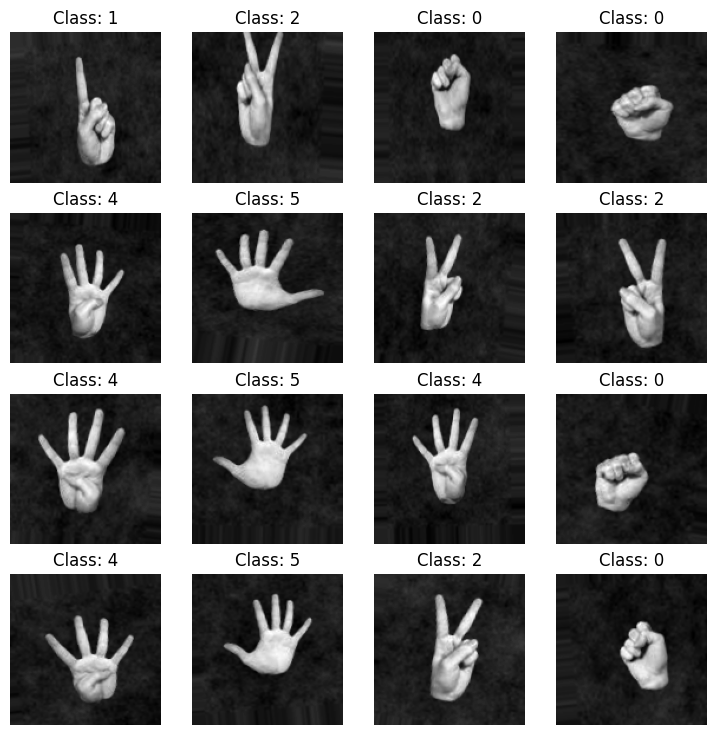

In [99]:
for X, y in train_gen:
    print(X.shape, y.shape)

    plt.figure(figsize=(9,9))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.axis('off')
        plt.title('Class: %d' % np.argmax(y[i]))
        img = np.uint8(255*X[i,:,:,0])
        plt.imshow(img, cmap='gray')
    break

In [57]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_4 (Flatten)         (None, 57600)             0         
                                                                 
 dense_8 (Dense)             (None, 128)              

In [58]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [59]:
callbacks_list = [
    EarlyStopping(monitor='val_loss', patience=10),
    ModelCheckpoint(filepath='model.h5', monitor='val_loss', save_best_only=True),
]

In [60]:
os.environ["CUDA_VISIBLE_DEVICES"]="2"
with tf.device('/cpu:0'):
    history = model.fit_generator(
        train_gen,
        steps_per_epoch=70,
        epochs=10,
        validation_data=test_gen,
        validation_steps=28,
        callbacks=callbacks_list
    )

Epoch 1/10


<ipython-input-60-4393cb8985be>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


70/70 [==============================] - 39s 547ms/step - loss: 1.6477 - accuracy: 0.2955 - val_loss: 0.9842 - val_accuracy: 0.8415
Epoch 2/10
70/70 [==============================] - 39s 564ms/step - loss: 1.0944 - accuracy: 0.5866 - val_loss: 0.4953 - val_accuracy: 0.8750
Epoch 3/10
70/70 [==============================] - 40s 566ms/step - loss: 0.8752 - accuracy: 0.6616 - val_loss: 0.3637 - val_accuracy: 0.9330
Epoch 4/10
70/70 [==============================] - 38s 538ms/step - loss: 0.7314 - accuracy: 0.6964 - val_loss: 0.2489 - val_accuracy: 0.9754
Epoch 5/10
70/70 [==============================] - 37s 533ms/step - loss: 0.6915 - accuracy: 0.7446 - val_loss: 0.2718 - val_accuracy: 0.9174
Epoch 6/10
70/70 [==============================] - 38s 546ms/step - loss: 0.5488 - accuracy: 0.7821 - val_loss: 0.2164 - val_accuracy: 0.9621
Epoch 7/10
70/70 [==============================] - 37s 524ms/step - loss: 0.5546 - accuracy: 0.7857 - val_loss: 0.1996 - val_accuracy: 0.9665
Epoch 8/10

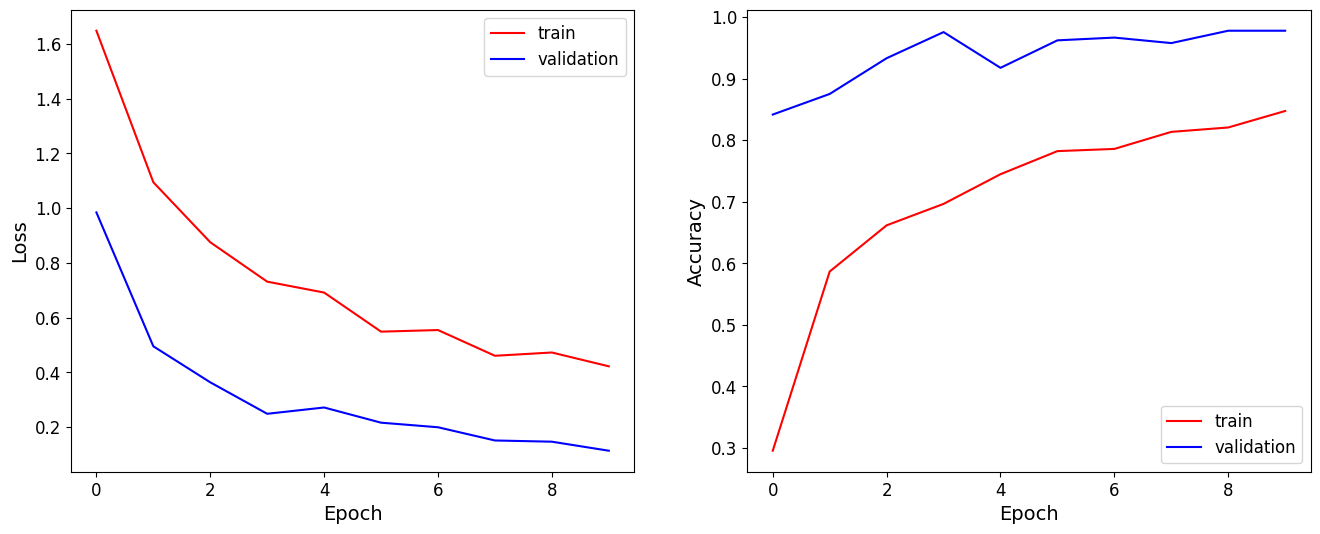

In [62]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
nepochs = len(history.history['loss'])
plt.plot(range(nepochs), history.history['loss'], 'r-', label='train')
plt.plot(range(nepochs), history.history['val_loss'], 'b-', label='validation')
plt.legend(prop={'size': 12})
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(range(nepochs), history.history['accuracy'], 'r-', label='train')
plt.plot(range(nepochs), history.history['val_accuracy'], 'b-', label='validation')
plt.legend(prop={'size': 12})
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.show()


In [97]:
X_test, y_test = [], []
for ibatch, (X, y) in enumerate(test_gen):
    X_test.append(X)
    y_test.append(y)
    ibatch += 1
    if (ibatch == 5*28): break

X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)
y_test = np.int32([np.argmax(r) for r in y_test])

y_pred = np.int32([np.argmax(r) for r in model.predict(X_test)])
match = (y_test == y_pred)
print('Testing Accuracy = %.2f%%' % (np.sum(match)*100/match.shape[0]))

70/70 [==============================] - 15s 209ms/step
Testing Accuracy = 97.92%


In [70]:
nomatch = (y_test != y_pred)
bad_pred = y_pred[nomatch]
bad_true = y_test[nomatch]
bad_img = X_test[nomatch]
print('%d number of bad predictions' % bad_pred.size)

48 number of bad predictions


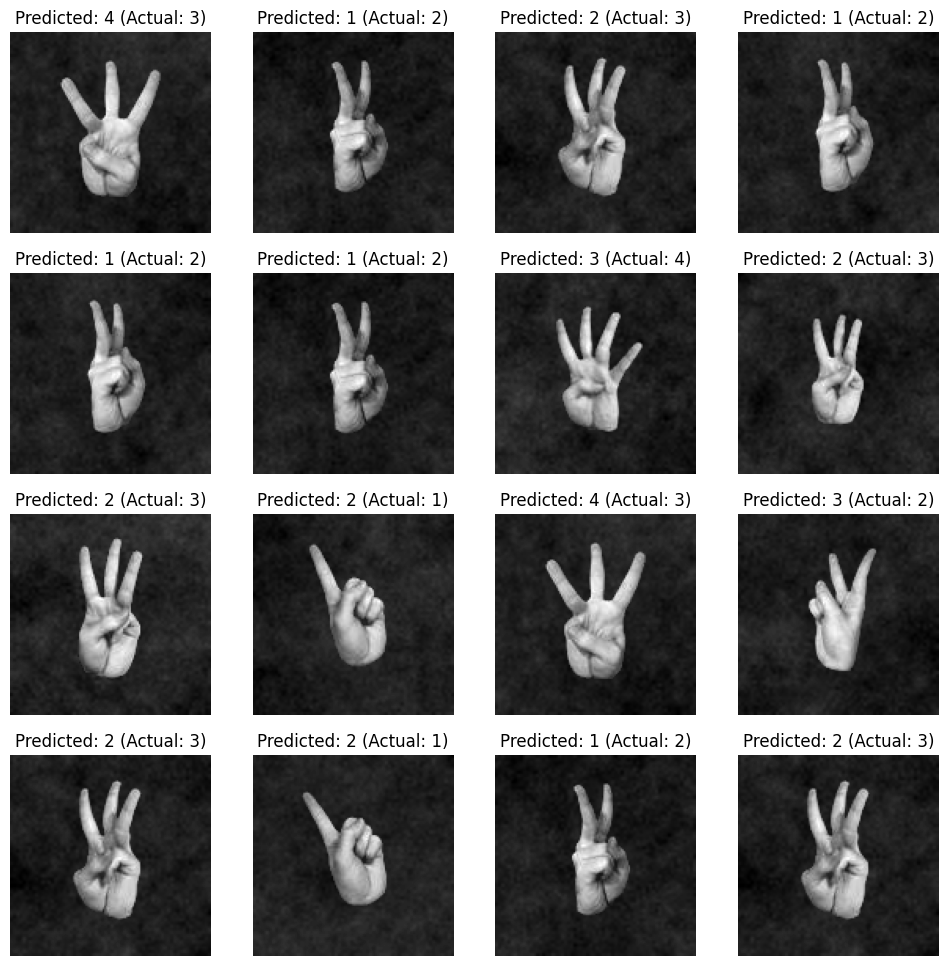

In [96]:
plt.figure(figsize=(12,12))
for i in range(min(bad_true.size,16)):
    plt.subplot(4,4,i+1)
    i+=20
    plt.title('Predicted: %d (Actual: %d)' % (bad_pred[i], bad_true[i]))
    plt.axis('off')
    plt.imshow(bad_img[i][:,:,0], cmap='gray')

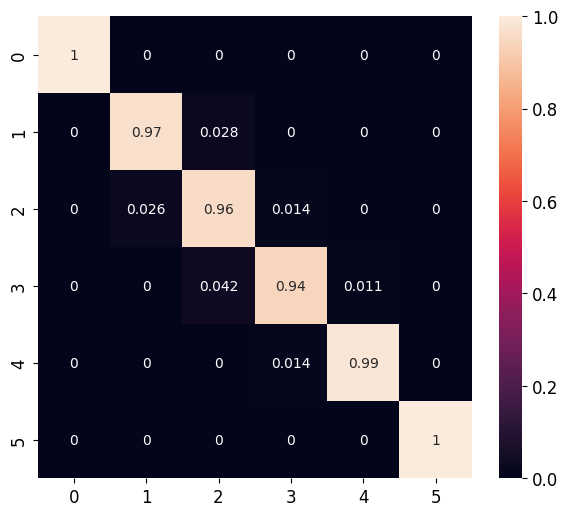

In [93]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
plt.figure(figsize=(7,6))
cm = confusion_matrix(y_test, y_pred)
cm = cm / cm.sum(axis=1)
sn.heatmap(cm, annot=True);

1/1 [==============================] - 0s 47ms/step


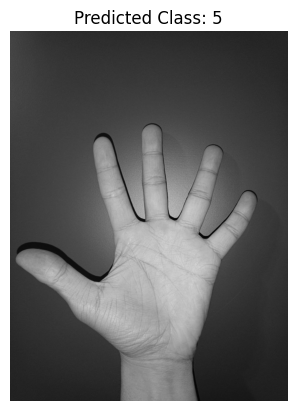

In [90]:
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

image_path = '/content/photo_5422750340299740501_y.jpg'

def preprocess_and_reshape_image(image_path, target_size=(128, 128)):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    resized_image = cv2.resize(image, target_size)
    reshaped_image = resized_image.reshape(1, target_size[0], target_size[1], 1)
    reshaped_image = reshaped_image / 255.0
    return reshaped_image

preprocessed_image = preprocess_and_reshape_image(image_path)

predictions = model.predict(preprocessed_image)

predicted_class = np.argmax(predictions)

image = cv2.imread(image_path)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Predicted Class: {}'.format(predicted_class))
plt.show()



1/1 [==============================] - 0s 77ms/step


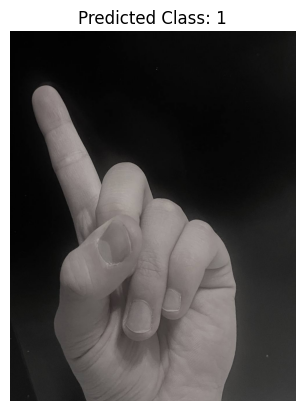

In [92]:
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

image_path = '/content/photo_5420464210812459383_y.jpg'

def preprocess_and_reshape_image(image_path, target_size=(128, 128)):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    resized_image = cv2.resize(image, target_size)
    reshaped_image = resized_image.reshape(1, target_size[0], target_size[1], 1)
    reshaped_image = reshaped_image / 255.0
    return reshaped_image

preprocessed_image = preprocess_and_reshape_image(image_path)

predictions = model.predict(preprocessed_image)

predicted_class = np.argmax(predictions)

image = cv2.imread(image_path)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Predicted Class: {}'.format(predicted_class))
plt.show()

